In [2]:
%matplotlib inline
import os
import sys
import pylab as plt
import numpy as np
from glob import glob
import fitsio
from collections import Counter
from IPython.core.display import HTML

In [3]:
from astrometry.util.fits import *
from astrometry.util.util import *
from astrometry.libkd.spherematch import match_radec
from tractor import *
from astrometry.util.starutil_numpy import *
from astrometry.util.plotutils import *

In [4]:
#C1 = fits_table('/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/survey-ccds-90prime-dr9.kd.fits')
#C2 = fits_table('/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/survey-ccds-mosaic-dr9.kd.fits')
#C3 = fits_table('/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/survey-ccds-decam-dr9.kd.fits')

C1 = fits_table('/global/cscratch1/sd/dstn/dr10-ubercal/survey-ccds-dr10-ubercal-prelim.fits')

Error reading from FITS object <class 'fitsio.hdu.table.TableHDU'> 
  file: /global/cscratch1/sd/dstn/dr10-ubercal/survey-ccds-dr10-ubercal-prelim.fits
  extension: 1
  type: BINARY_TBL
  rows: 15523579
  column info:
    image_filename    S120  
    image_hdu           i2  
    camera              S5  
    expnum              i8  
    plver               S8  
    procdate           S19  
    plprocid            S7  
    ccdname             S3  
    object             S35  
    propid             S10  
    filter              S1  
    exptime             f4  
    mjd_obs             f8  
    airmass             f4  
    fwhm                f4  
    width               i2  
    height              i2  
    ra_bore             f8  
    dec_bore            f8  
    crpix1              f4  
    crpix2              f4  
    crval1              f8  
    crval2              f8  
    cd1_1               f4  
    cd1_2               f4  
    cd2_1               f4  
    cd2_2               f4  

KeyboardInterrupt: 

In [4]:
B = fits_table('/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/survey-bricks.fits.gz')

In [6]:
Counter(C1.ccd_cuts).most_common(5)

[(0, 13027247),
 (32832, 1984085),
 (33280, 85238),
 (33344, 77260),
 (34880, 72912)]

In [7]:
brad = np.sqrt(2) * 0.25 / 2.

In [9]:
#I1,J1,_ = match_radec(B.ra, B.dec, C1.ra, C1.dec, brad + 4096 * np.sqrt(2) / 2. * 0.454 / 3600)
#I2,J2,_ = match_radec(B.ra, B.dec, C2.ra, C2.dec, brad + 4096 * np.sqrt(2) / 2. * 0.262 / 3600)
#I3,J3,_ = match_radec(B.ra, B.dec, C3.ra, C3.dec, brad + np.hypot(4096, 2048) / 2. * 0.262 / 3600)

I1,J1,_ = match_radec(B.ra, B.dec, C1.ra, C1.dec, brad + np.hypot(4096, 2048) / 2. * 0.262 / 3600)
II = I1

In [ ]:
#II = np.unique(np.hstack((I1,I2,I3)))

In [ ]:
#len(II) * 0.25**2

In [ ]:
brickarea = (B.dec2 - B.dec1) * (B.ra2 - B.ra1) * np.cos(np.deg2rad((B.dec1+B.dec2)/2.))

In [ ]:
np.sum(brickarea[II])

In [ ]:
#plt.plot(B.ra[II], B.dec[II], 'b.');

In [19]:
W,H = 2000, 1000
ra_center = 120.
wcs = anwcs_create_allsky_hammer_aitoff2(ra_center, 0., W, H)

In [16]:
bb = np.zeros((H,W), bool)
ok,xx,yy = wcs.radec2pixelxy(B.ra[II], B.dec[II])
print(Counter(ok))
xx = np.round(xx-1).astype(int)
yy = np.round(yy-1).astype(int)
xx.min(), yy.min(), xx.max(), yy.max()

Counter({True: 92280730})


(100, 49, 1899, 734)

In [17]:
bb[yy,xx] = True
#plt.imshow(bb, origin='lower');

In [53]:
#A1 = fits_table('/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/ccds-annotated-90prime-dr9.kd.fits')
#A2 = fits_table('/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/ccds-annotated-mosaic-dr9.kd.fits')
#A3 = fits_table('/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/ccds-annotated-decam-dr9.kd.fits')

A3 = fits_table('/global/cscratch1/sd/dstn/dr10-ubercal/ccds-annotated-dr10-ubercal-prelim.fits',
                columns='width height psfnorm_mean galnorm_mean filter ra dec sig1 fwhm'.split())
A3.ra_center = A3.ra
A3.dec_center = A3.dec

#columns='ra_center dec_center width height psfnorm_mean galnorm_mean filter ra dec sig1 fwhm'.split())

In [ ]:
# GAH, ra_center = dec_center = 0 for many

In [54]:
#A1.pixscale = 0.454
#A2.pixscale = 0.262
A3.pixscale = 0.262

In [55]:
#A1.ra_lo = A1.ra_center - A1.width/2. * A1.pixscale / 3600. / np.cos(np.deg2rad(A1.dec_center))
#A1.ra_hi = A1.ra_center + A1.width/2. * A1.pixscale / 3600. / np.cos(np.deg2rad(A1.dec_center))
#A1.dec_lo = A1.dec_center - A1.height/2. * A1.pixscale / 3600.
#A1.dec_hi = A1.dec_center + A1.height/2. * A1.pixscale / 3600.

#A2.ra_lo = A2.ra_center - A2.width/2. * A2.pixscale / 3600. / np.cos(np.deg2rad(A2.dec_center))
#A2.ra_hi = A2.ra_center + A2.width/2. * A2.pixscale / 3600. / np.cos(np.deg2rad(A2.dec_center))
#A2.dec_lo = A2.dec_center - A2.height/2. * A2.pixscale / 3600.
#A2.dec_hi = A2.dec_center + A2.height/2. * A2.pixscale / 3600.

A3.ra_lo = A3.ra_center - A3.height/2. * A3.pixscale / 3600. / np.cos(np.deg2rad(A3.dec_center))
A3.ra_hi = A3.ra_center + A3.height/2. * A3.pixscale / 3600. / np.cos(np.deg2rad(A3.dec_center))
A3.dec_lo = A3.dec_center - A3.width/2. * A3.pixscale / 3600.
A3.dec_hi = A3.dec_center + A3.width/2. * A3.pixscale / 3600.

#A = merge_tables([A1,A2,A3])
A = A3

In [8]:
from astrometry.util.plotutils import plothist

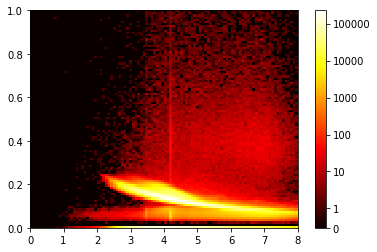

In [9]:
loghist(A.fwhm, A.psfnorm_mean, range=((0,8),(0, 1)));

In [10]:
Counter(A.fwhm > 0)

Counter({True: 15523579})

In [13]:
Counter(A.psfnorm_mean > 0)

Counter({True: 11181109, False: 4342470})

In [11]:
Counter(A.sig1 > 0)

Counter({True: 15522884, False: 695})

In [56]:
#A.cut(A.psfnorm_mean > 0)

A.cut(A.sig1 > 0)

In [57]:
#A.psfiv = 1./(A.sig1 / A.psfnorm_mean)**2
#A.galiv = 1./(A.sig1 / A.galnorm_mean)**2

A.psfnorm_mean = 1./(2. * np.sqrt(np.pi) * (A.fwhm/2.35))
A.psfiv = 1./(A.sig1 / A.psfnorm_mean)**2


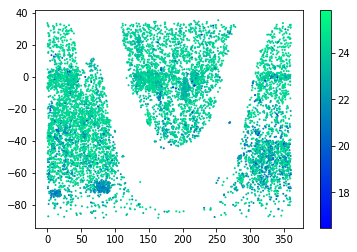

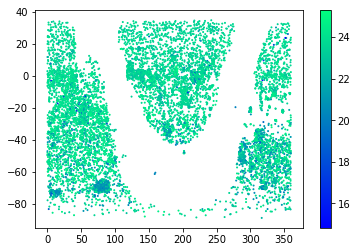

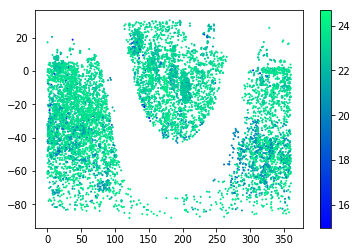

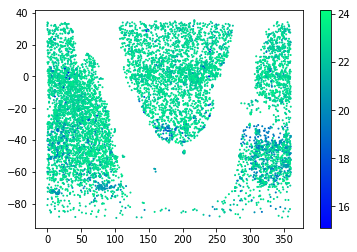

In [17]:
for band in 'griz':
    I = np.flatnonzero(A.filter == band)
    I = np.random.permutation(I)[:10000]
    plt.scatter(A.ra[I], A.dec[I], c=-2.5*(np.log10(5./np.sqrt(A.psfiv[I]))-9), s=1, cmap='winter')
    plt.colorbar()
    plt.show()

In [58]:
xx,yy = np.meshgrid(np.arange(W), np.arange(H))
ok,rr,dd = wcs.pixelxy2radec(xx, yy)
print(Counter(ok.flat))
xx = xx[ok]
yy = yy[ok]
rr = rr[ok]
dd = dd[ok]
len(dd)

Counter({True: 1273264, False: 726736})


1273264

In [59]:
min(dd)

-89.82959415500078

In [38]:
#A.radius = np.hypot(A.width, A.height) / 2. * A.pixscale / 3600.

In [60]:
#R = 0.454 * np.hypot(4096,4096)/2. / 3600.
R = 0.262 * np.hypot(2048,4096)/2. / 3600.

In [63]:
depths = {}
for band in 'griz':
    depth = np.zeros((H,W), np.float32)
    depths[band] = depth

    B = A[A.filter == band]
    print(len(B), 'in', band)
    I,J,_ = match_radec(rr, dd, B.ra, B.dec, R)
    print('Matched', len(I))
    print('min dec:', min(dd[I]))
    K = np.flatnonzero((rr[I] > B.ra_lo[J]) * (rr[I] < B.ra_hi[J]) *
                       (dd[I] > B.dec_lo[J]) * (dd[I] < B.dec_hi[J]))
    I = I[K]
    J = J[K]
    print('Contained', len(I))
    print('min dec:', min(dd[I]))
    for x,y,piv in zip(xx[I], yy[I], B.psfiv[J]):
    #for x,y,piv in zip(xx[I], yy[I], B.galiv[J]):
        depth[y,x] += piv

4224576 in g
Matched 11383528
min dec: -89.57748437491915
Contained 5780418
min dec: -89.57748437491915
3967993 in r
Matched 10677939
min dec: -89.57748437491915
Contained 5439629
min dec: -89.57748437491915
3069399 in i
Matched 8269188
min dec: -89.49115090961143
Contained 4207746
min dec: -89.45307051564988
3557777 in z
Matched 9578767
min dec: -89.52380249697613
Contained 4891335
min dec: -89.52380249697613


In [44]:
from tractor.sfd import SFDMap
sfd = SFDMap()
filts = ['%s %s' % ('DES', f) for f in 'griz']
ebv,ext = sfd.extinction(filts, rr, dd, get_ebv=True)

/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


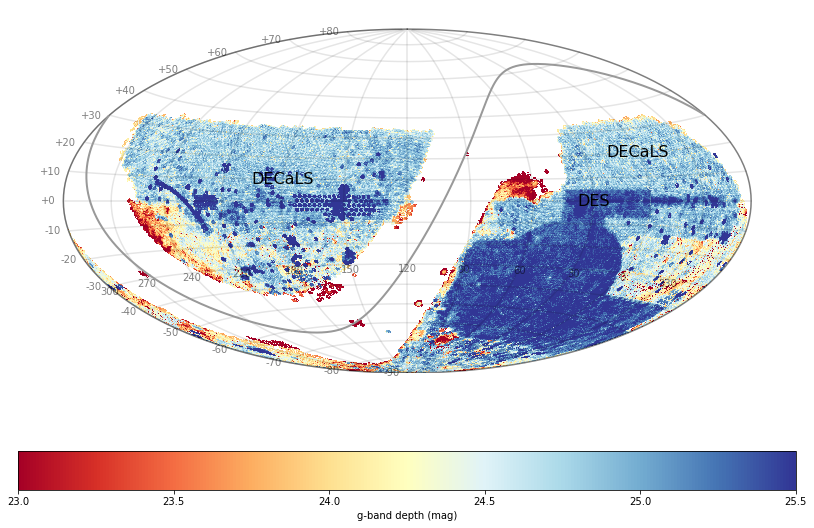

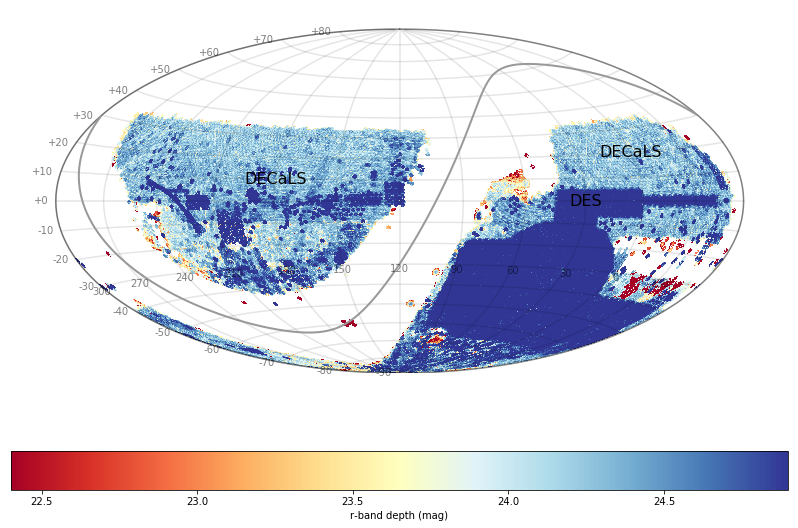

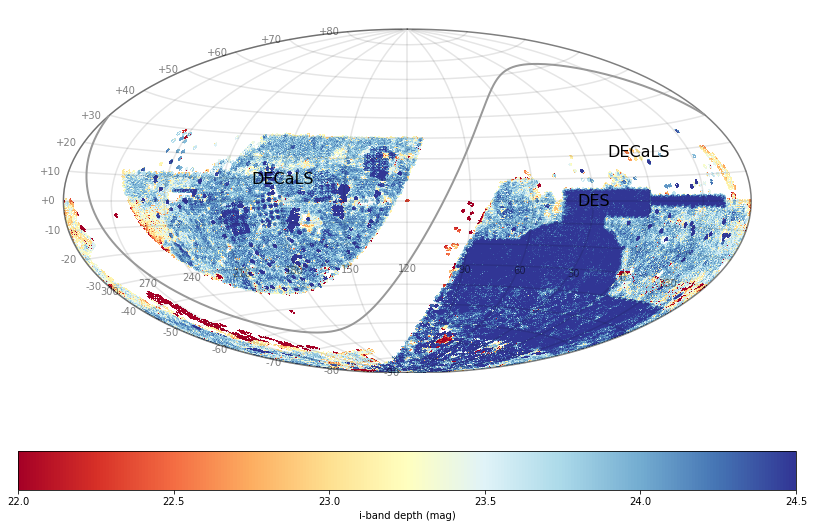

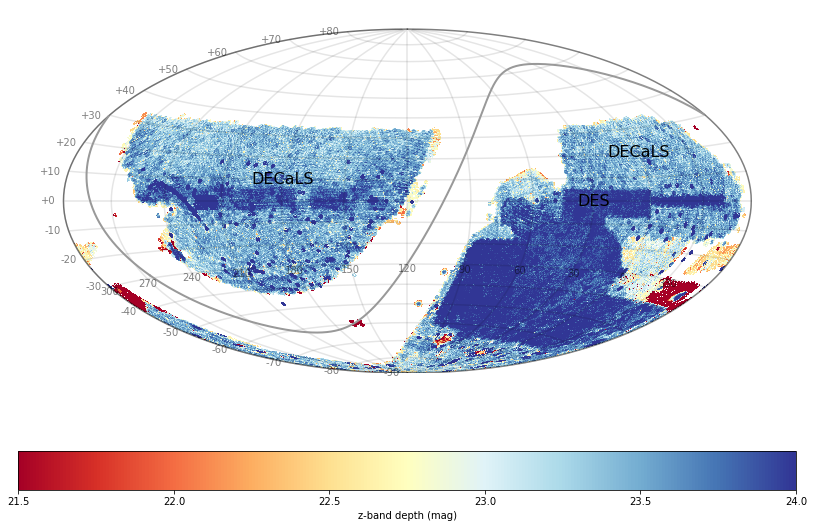

In [65]:
for iband,band in enumerate('griz'):
    plt.figure(figsize=(12,8))
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)
    lo,hi = { 'g':(23.0,25.5), 'r':(22.4,24.9), 'i':(22.0,24.5), 'z':(21.5,24.0) }[band]
    plt.clf()
    depth = -2.5 * (np.log10(5. * 1./np.sqrt(depths[band]))-9.)
    extmap = np.zeros_like(depth)
    extmap[yy,xx] = ext[:,iband]
    plt.imshow(depth - extmap, origin='lower', vmin=lo, vmax=hi, cmap='RdYlBu')
    c = plt.colorbar(orientation='horizontal')
    c.set_label('%s-band depth (mag)' % band)

    dec_lo = -90
        
    dec_gridlines = list(range(dec_lo, 90, 10))
    dec_gridlines_ras = np.arange(ra_center-180, ra_center+180, 1)
    ra_gridlines = range(0, 360, 30)
    ra_gridlines_decs = np.arange(dec_lo, 90, 1.)
    for d in dec_gridlines:
        rr = dec_gridlines_ras
        dd = np.zeros_like(rr) + d
        ok,x,y = wcs.radec2pixelxy(rr, dd)
        plt.plot(x, y, 'k-', alpha=0.1)
    for r in ra_gridlines:
        dd = ra_gridlines_decs
        rr = np.zeros_like(dd) + r
        ok,x,y = wcs.radec2pixelxy(rr, dd)
        plt.plot(x, y, 'k-', alpha=0.1)

    ra_gridlines2 = [ra_center-180, ra_center+180]
    ra_gridlines2_decs = np.arange(dec_lo, 91, 1.)
    for r in ra_gridlines2:
        dd = ra_gridlines2_decs
        rr = np.zeros_like(dd) + r
        ok,x,y = wcs.radec2pixelxy(rr, dd)
        plt.plot(x, y, 'k-', alpha=0.5)
    
    ra_labels = ra_gridlines
    dec_labels = dec_gridlines
    ra_labels_dec = -30
    dec_labels_ra = ra_center+180
    
    ok,xi,yi = wcs.radec2pixelxy(ra_labels, ra_labels_dec)
    for x,y,v in zip(xi, yi, ra_labels):
        plt.text(x, y, '%i'%(v%360), ha='center', va='top', alpha=0.5)
    ok,xi,yi = wcs.radec2pixelxy(dec_labels_ra, dec_labels)
    for x,y,v in zip(xi, yi, dec_labels):
        plt.text(x-20, y, '%+i'%v, ha='right', va='center', alpha=0.5)

    # Galactic plane
    ll = np.linspace(0., 360., 720)
    bb = np.zeros_like(ll)
    rr,dd = lbtoradec(ll, bb)
    ok,x,y = wcs.radec2pixelxy(rr, dd)
    # Plot segments that are above Dec=-30 and not discontinuous
    d = np.append([0], np.hypot(np.diff(x), np.diff(y)))
    ok = (d < 100)# * (dd > -30)
    istart = 0
    while istart < len(ok):
        while istart < len(ok) and ok[istart] == False:
            istart += 1
        iend = istart
        while iend < len(ok) and ok[iend] == True:
            iend += 1
        if iend != istart:
            #print('Plotting from', istart, 'to', iend, 'ok', ok[istart:iend])
            plt.plot(x[istart:iend], y[istart:iend], '-', color='0.6', lw=2)
        istart = iend

    # Label regions
    for r,d,n in [(30, 0, 'DES'),
                  (0, 20, 'DECaLS'),
                  (180, 10, 'DECaLS'),
                  #(180, 50, 'MzLS+BASS')
                 ]:
        ok,x,y = wcs.radec2pixelxy(r, d)
        plt.text(x, y, n, fontsize=16, ha='center', va='center')
    
    plt.xticks([])
    plt.yticks([])
    #plt.axis('equal');
    ax = [0,W, 0.05*H, H]
    plt.axis(ax)
    plt.axis('equal')
    plt.axis(ax)
    plt.gca().set_frame_on(False)
    plt.savefig('depth-map-%s.png' % band)
    plt.show()